# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
from glob import glob
from scipy.stats import gaussian_kde

# Data Loading and EDA

Loading embeddings for dimensionality reduction...
Task close-book_qa: shape (1000, 4096)
Task coreference_resolution: shape (1000, 4096)
Task extractive_qa: shape (1000, 4096)
Task multiple-choice_qa: shape (1000, 4096)
Task natural_language_inference: shape (1000, 4096)
Task paraphrase_identification: shape (1000, 4096)
Task sentence_completion: shape (1000, 4096)
Task sentiment: shape (1000, 4096)
Task structure-to-text: shape (1000, 4096)
Task summarization: shape (1000, 4096)
Task topic_classification: shape (1000, 4096)
Task word_sense_disambiguation: shape (1000, 4096)
Combined shape: (12000, 4096)
Loaded 12000 samples with shape (12000, 4096)
Unique tasks: 12
Applying PCA...
Applying t-SNE...
Saved visualization to dimension_reduction_visualization.png


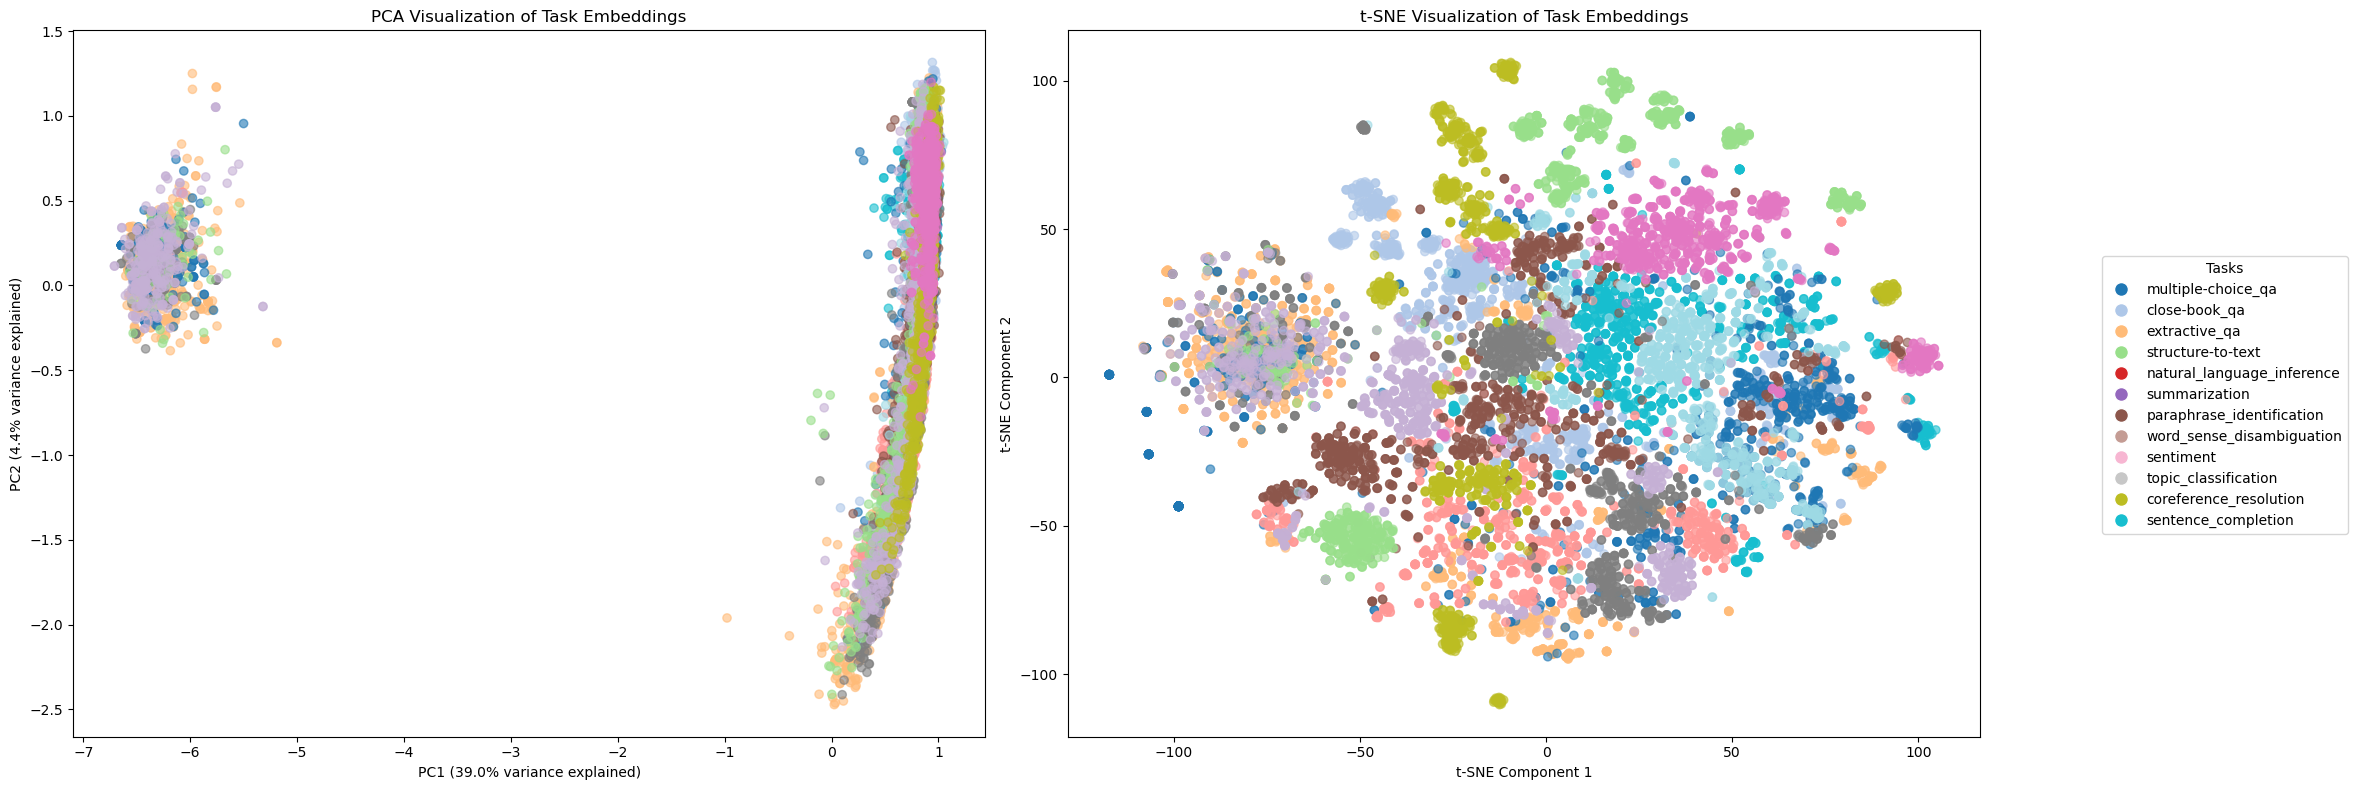

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
npy_files=[]

def load_embeddings(folder_path, expected_shape=(1000, 4096)):
    """
    Load all .npy files 
    """
    all_embeddings = []
    all_labels = []
    
    npy_files = sorted(glob(os.path.join(folder_path, '*.npy')))
    
    if not npy_files:
        raise ValueError(f"No .npy files found in {folder_path}")
    
    for file_path in npy_files:
        try:
            embeddings = np.load(file_path)
            label = os.path.basename(file_path).replace('.npy', '')
            
            if embeddings.shape != expected_shape:
                print(f"Warning: {label} has shape {embeddings.shape}, expected {expected_shape}")
                continue
                
            print(f"Task {label}: shape {embeddings.shape}")
            
            all_embeddings.append(embeddings)
            all_labels.extend([label] * len(embeddings))
            
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            continue
    
    if not all_embeddings:
        raise ValueError("No valid embeddings were loaded")
    
    combined_embeddings = np.concatenate(all_embeddings, axis=0)
    print(f"Combined shape: {combined_embeddings.shape}")
    
    return combined_embeddings, all_labels

def create_visualization(X, labels, method, results):
    """
    Create visualization - PCA and t-SNE
    """
    unique_labels = list(set(labels))
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = [label_to_num[label] for label in labels]
    
    scatter = plt.scatter(X[:, 0], X[:, 1], 
                         c=numeric_labels,
                         cmap='tab20',
                         alpha=0.6)
    
    plt.title(f'{method} Visualization of Task Embeddings')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    
    if method == 'PCA':
        var_explained = results.explained_variance_ratio_
        plt.xlabel(f'PC1 ({var_explained[0]:.1%} variance explained)')
        plt.ylabel(f'PC2 ({var_explained[1]:.1%} variance explained)')

def visualize_embeddings(X, labels):
    """
    Apply PCA and t-SNE and create visualizations
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    print("Applying PCA...")
    pca = PCA(n_components=2, random_state=0)
    pca_results = pca.fit_transform(X)
    
    print("Applying t-SNE...")
    tsne = TSNE(random_state=0, n_iter=1000)
    tsne_results = tsne.fit_transform(X)
    
    plt.sca(ax1)
    create_visualization(pca_results, labels, 'PCA', pca)
    
    plt.sca(ax2)
    create_visualization(tsne_results, labels, 't-SNE', tsne)
    
    unique_labels = list(set(labels))
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=plt.cm.tab20(label_to_num[label] / len(unique_labels)), 
                                 label=label, markersize=10)
                      for label in unique_labels]
    
    fig.legend(handles=legend_elements,
              title="Tasks",
              bbox_to_anchor=(1.05, 0.5),
              loc='center left')
    
    plt.tight_layout()
    plt.savefig('dimension_reduction_visualization.png', bbox_inches='tight', dpi=300)
    print("Saved visualization to dimension_reduction_visualization.png")
    plt.show()


# Folder containing .npy files
plots_folder = "plots"

# Load embeddings and create visualizations
print("Loading embeddings for dimensionality reduction...")
X, labels = load_embeddings(plots_folder)
print(f"Loaded {len(X)} samples with shape {X.shape}")
print(f"Unique tasks: {len(set(labels))}")
visualize_embeddings(X, labels)



# EDA-RidgePlots

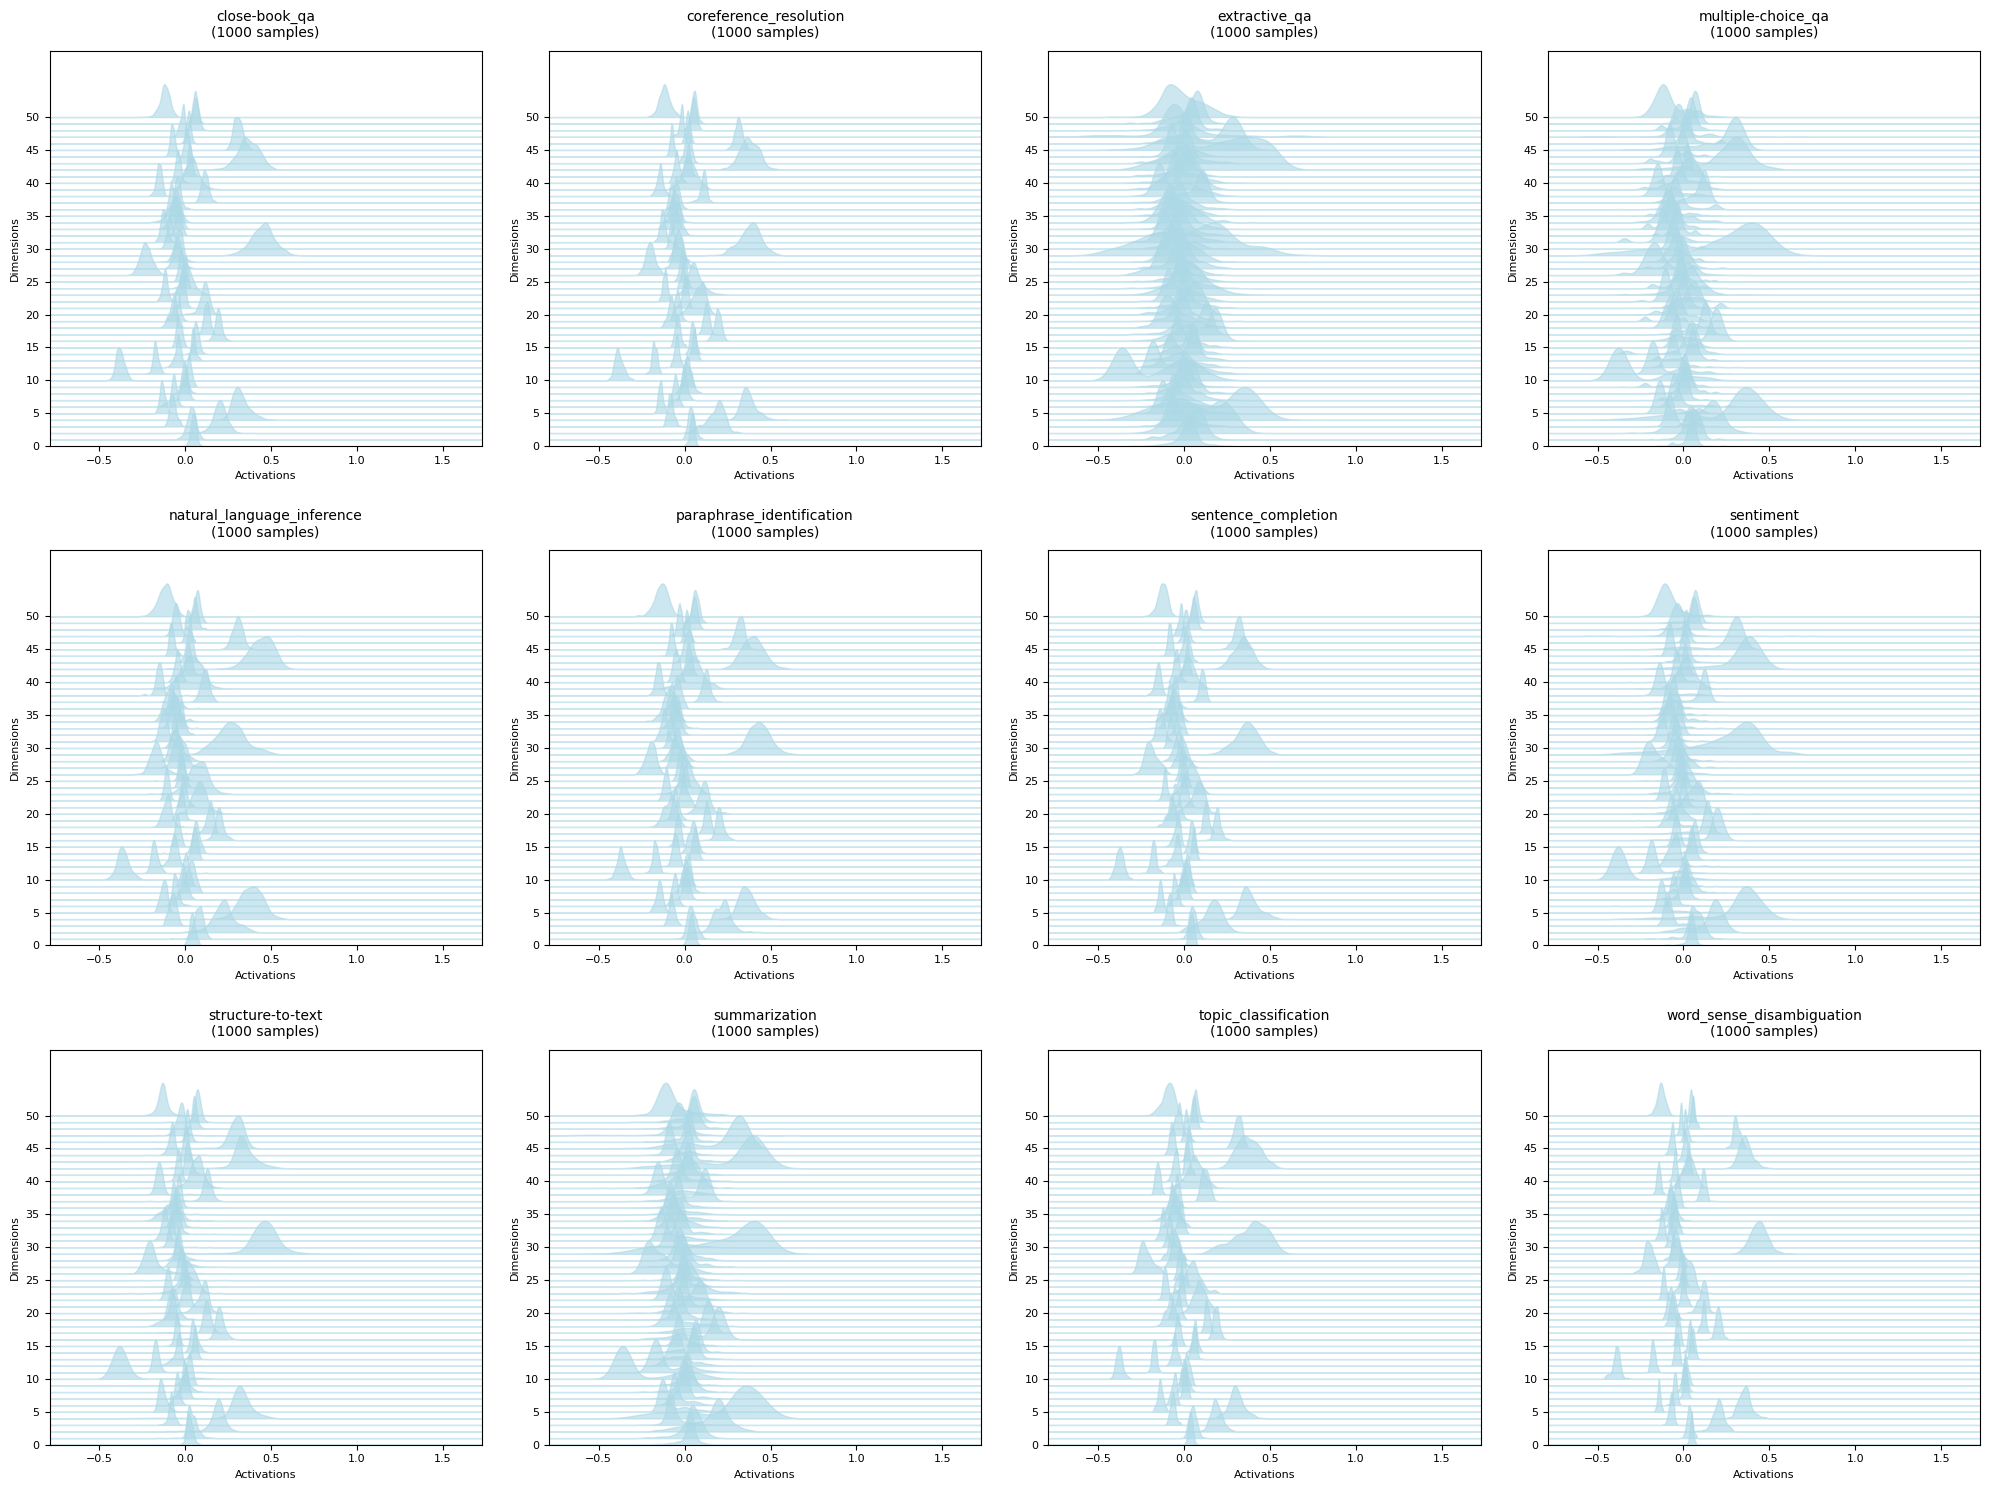

In [4]:
import numpy as np
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy.stats import gaussian_kde

# Set random seed for reproducibility
np.random.seed(42)

def plot_ridgeplot(ax, data, name, global_min, global_max, n_plots=51):
    # Ensure data is 2D
    if data.ndim == 1:
        data = data.reshape(-1, 1)
        
    n_plots = min(n_plots, data.shape[1])
    data_sample = data[:, :n_plots]
    positions = np.linspace(0, 1, n_plots)
    
    reduction_factor = 0.8
    midpoint = (global_min + global_max) / 2
    new_width = (global_max - global_min) * reduction_factor
    new_global_min = midpoint - new_width / 2
    new_global_max = midpoint + new_width / 2
    x = np.linspace(new_global_min, new_global_max, 1000)

    for i, (pos, col) in enumerate(zip(positions, data_sample.T)):
        kde = gaussian_kde(col)
        y = kde(x)
        y = y / y.max() * 0.1
        ax.fill_between(x, pos, pos + y, alpha=0.6, color='#ADD8E6')

    ax.set_title(f"{name}\n({data.shape[0]} samples)", fontsize=10, pad=10)
    ax.set_xlabel('Activations', fontsize=8)
    ax.set_ylabel('Dimensions', fontsize=8)
    ax.set_yticks(positions[::5])
    ax.set_yticklabels(range(0, n_plots, 5))
    ax.set_ylim(0, 1.2)
    ax.set_xlim(new_global_min, new_global_max)
    ax.tick_params(axis='both', which='major', labelsize=8)

def create_ridge_plots(plots_folder, loaded_data=None, loaded_files=None):
    """
    Create ridge plots
    
    Args:
        plots_folder: Folder containing .npy files
        loaded_data: List of already loaded numpy arrays (optional)
        loaded_files: List of corresponding filenames (optional)
    """
   
    all_data = loaded_data
    npy_files = loaded_files

    n_rows = (len(npy_files) + 3) // 4
    n_cols = min(4, len(npy_files))

    fig = plt.figure(figsize=(20, 5 * n_rows))

    # Calculate global min and max
    global_min = min(np.min(data) for data in all_data)
    global_max = max(np.max(data) for data in all_data)

    # Create ridge plots
    for i, (npy_file, data) in enumerate(zip(npy_files, all_data)):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plot_ridgeplot(ax, data, npy_file.replace('.npy', ''), 
                      global_min, global_max)

    plt.tight_layout(h_pad=2, w_pad=2)
    return fig

# Example usage:
plots_folder = "plots"

# If X and labels are already loaded from previous code
if 'X' in locals() and 'labels' in locals():
    
    unique_labels = sorted(set(labels))
    data_by_label = {label: [] for label in unique_labels}
    
    for x, label in zip(X, labels):
        data_by_label[label].append(x)
    
    loaded_data = [np.array(data_by_label[label]) for label in unique_labels]
    loaded_files = [f"{label}.npy" for label in unique_labels]
    
    fig = create_ridge_plots(plots_folder, loaded_data, loaded_files)
else:
    # Load data fresh if not already loaded
    fig = create_ridge_plots(plots_folder)

plt.show()

# Optimal K

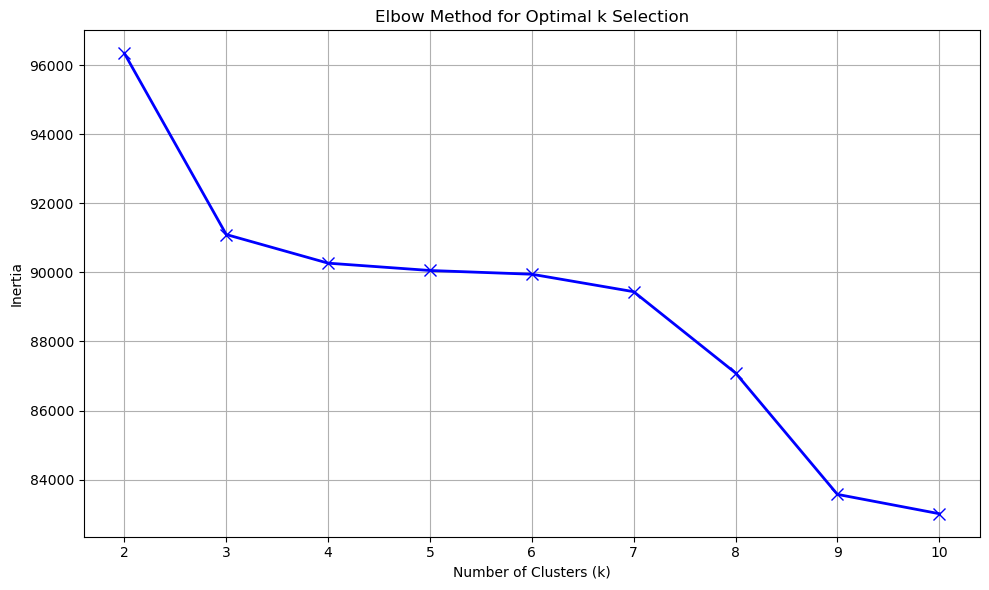

In [5]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def find_optimal_k(embeddings, k_range=range(2, 11)):
    """
    Find optimal number of clusters using elbow method
    """
    inertias = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(list(k_range), inertias, 'bx-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k Selection')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return inertias

# Main execution using already loaded data
if 'X' in locals():
    inertias = find_optimal_k(X)
else:
    print("Error: No data loaded. Please run the previous code to load the embeddings first.")

# Cluster Plots


Overall cluster distribution:
Cluster 0: 3269 samples
Cluster 1: 4170 samples
Cluster 2: 1362 samples
Cluster 3: 3199 samples

Cluster 0 composition:
close-book_qa: 75 samples (2.3%)
coreference_resolution: 86 samples (2.6%)
extractive_qa: 393 samples (12.0%)
multiple-choice_qa: 302 samples (9.2%)
natural_language_inference: 845 samples (25.8%)
paraphrase_identification: 180 samples (5.5%)
sentence_completion: 205 samples (6.3%)
sentiment: 391 samples (12.0%)
structure-to-text: 243 samples (7.4%)
summarization: 283 samples (8.7%)
topic_classification: 260 samples (8.0%)
word_sense_disambiguation: 6 samples (0.2%)
Total samples: 3269

Counts for Cluster 0 ridgeplot:
Total samples in ridgeplot: 3269


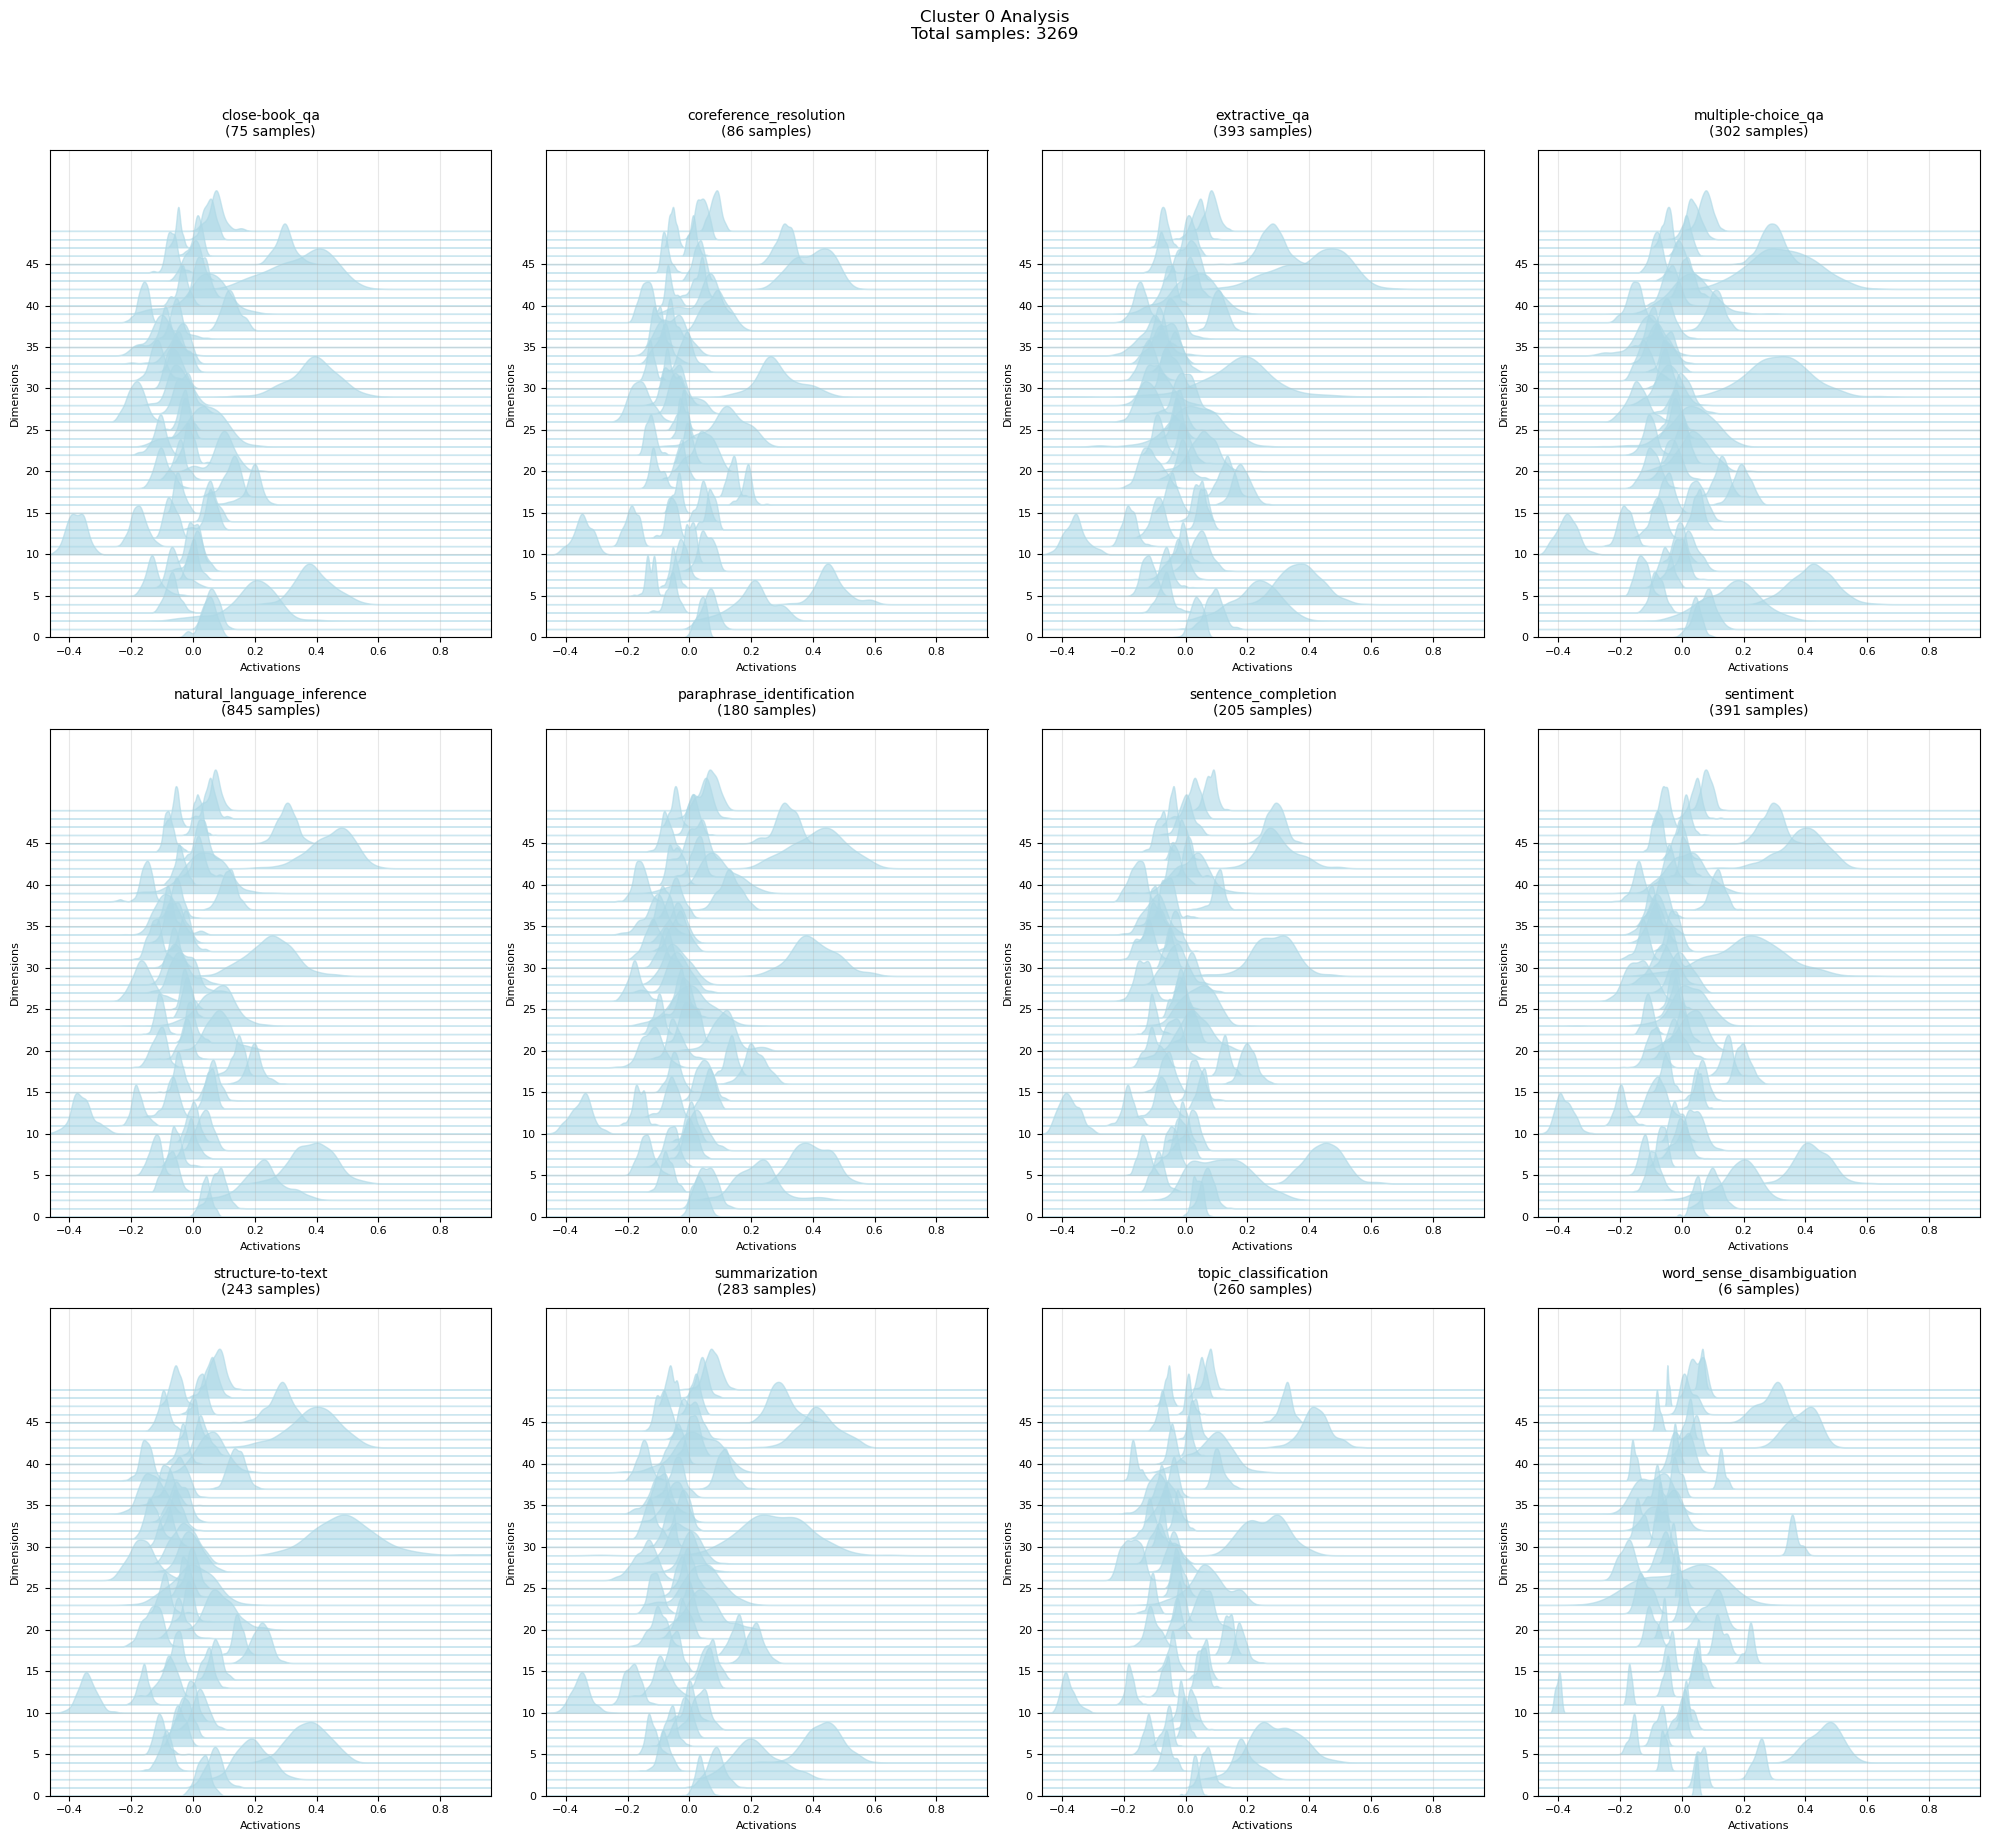


Cluster 1 composition:
close-book_qa: 767 samples (18.4%)
coreference_resolution: 309 samples (7.4%)
extractive_qa: 58 samples (1.4%)
multiple-choice_qa: 161 samples (3.9%)
natural_language_inference: 69 samples (1.7%)
paraphrase_identification: 470 samples (11.3%)
sentence_completion: 432 samples (10.4%)
sentiment: 390 samples (9.4%)
structure-to-text: 274 samples (6.6%)
summarization: 384 samples (9.2%)
topic_classification: 730 samples (17.5%)
word_sense_disambiguation: 126 samples (3.0%)
Total samples: 4170

Counts for Cluster 1 ridgeplot:
Total samples in ridgeplot: 4170


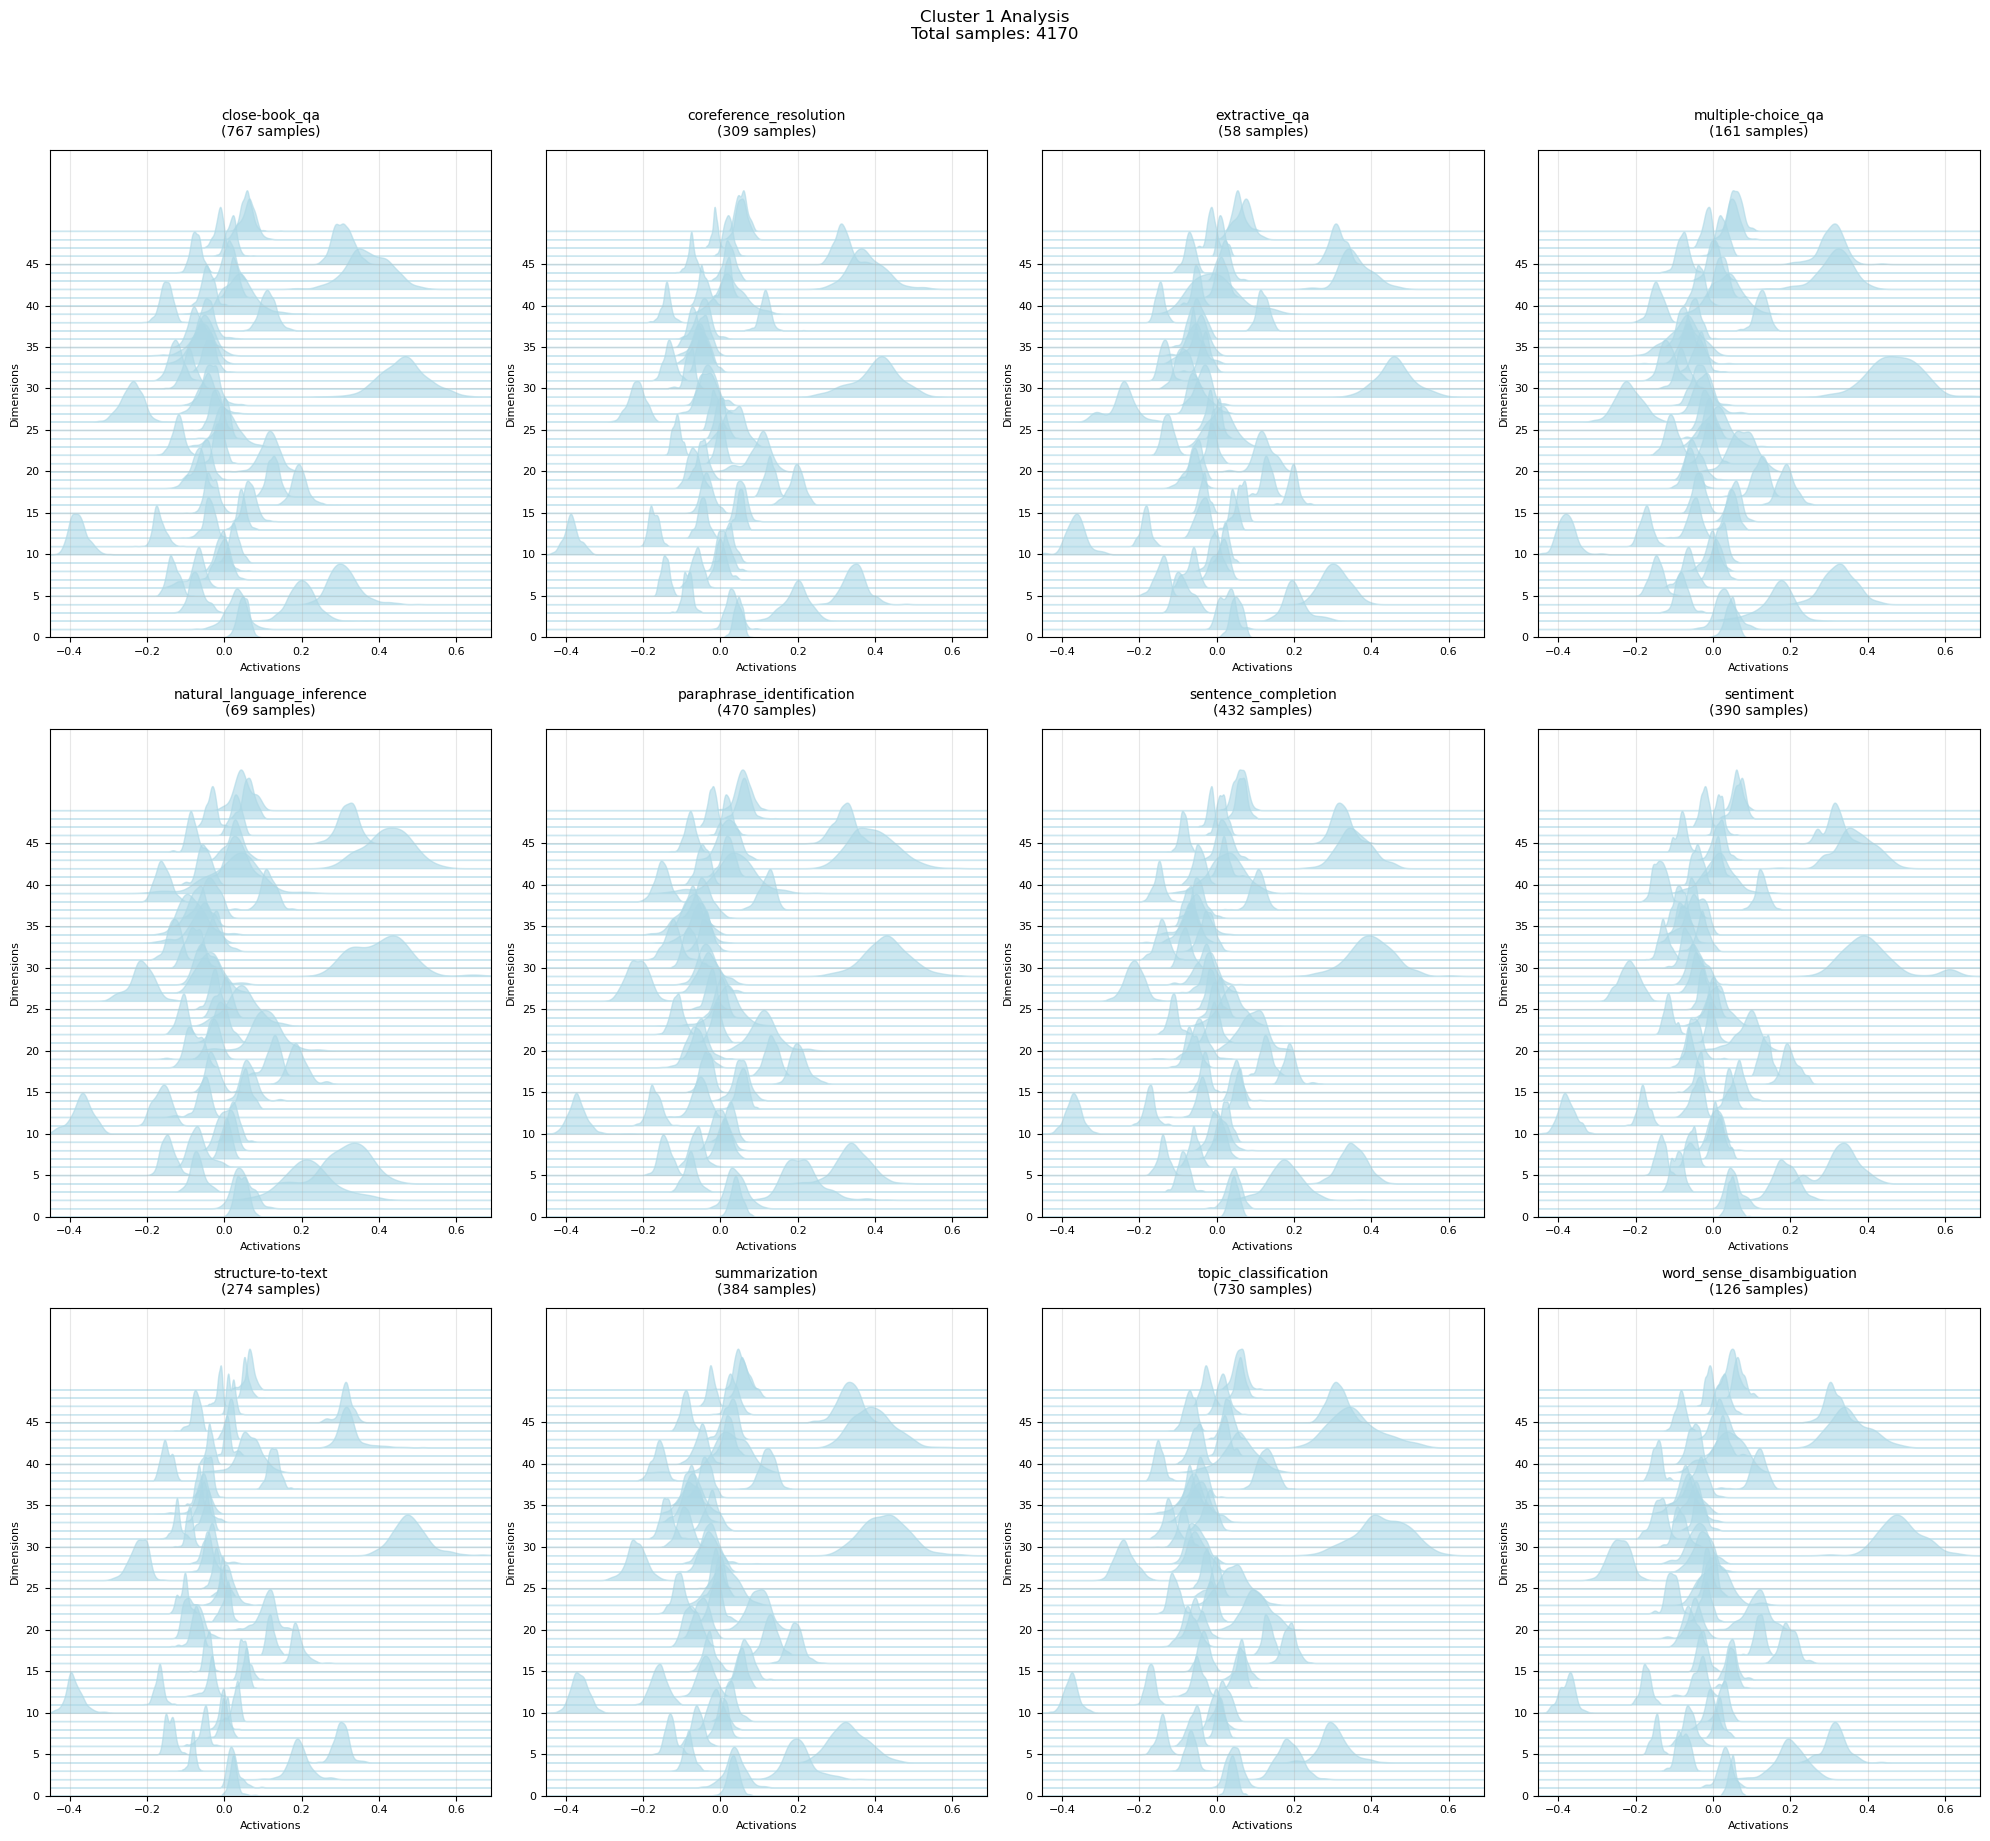


Cluster 2 composition:
extractive_qa: 542 samples (39.8%)
multiple-choice_qa: 291 samples (21.4%)
natural_language_inference: 8 samples (0.6%)
sentiment: 152 samples (11.2%)
structure-to-text: 69 samples (5.1%)
summarization: 300 samples (22.0%)
Total samples: 1362

Counts for Cluster 2 ridgeplot:
Total samples in ridgeplot: 1362


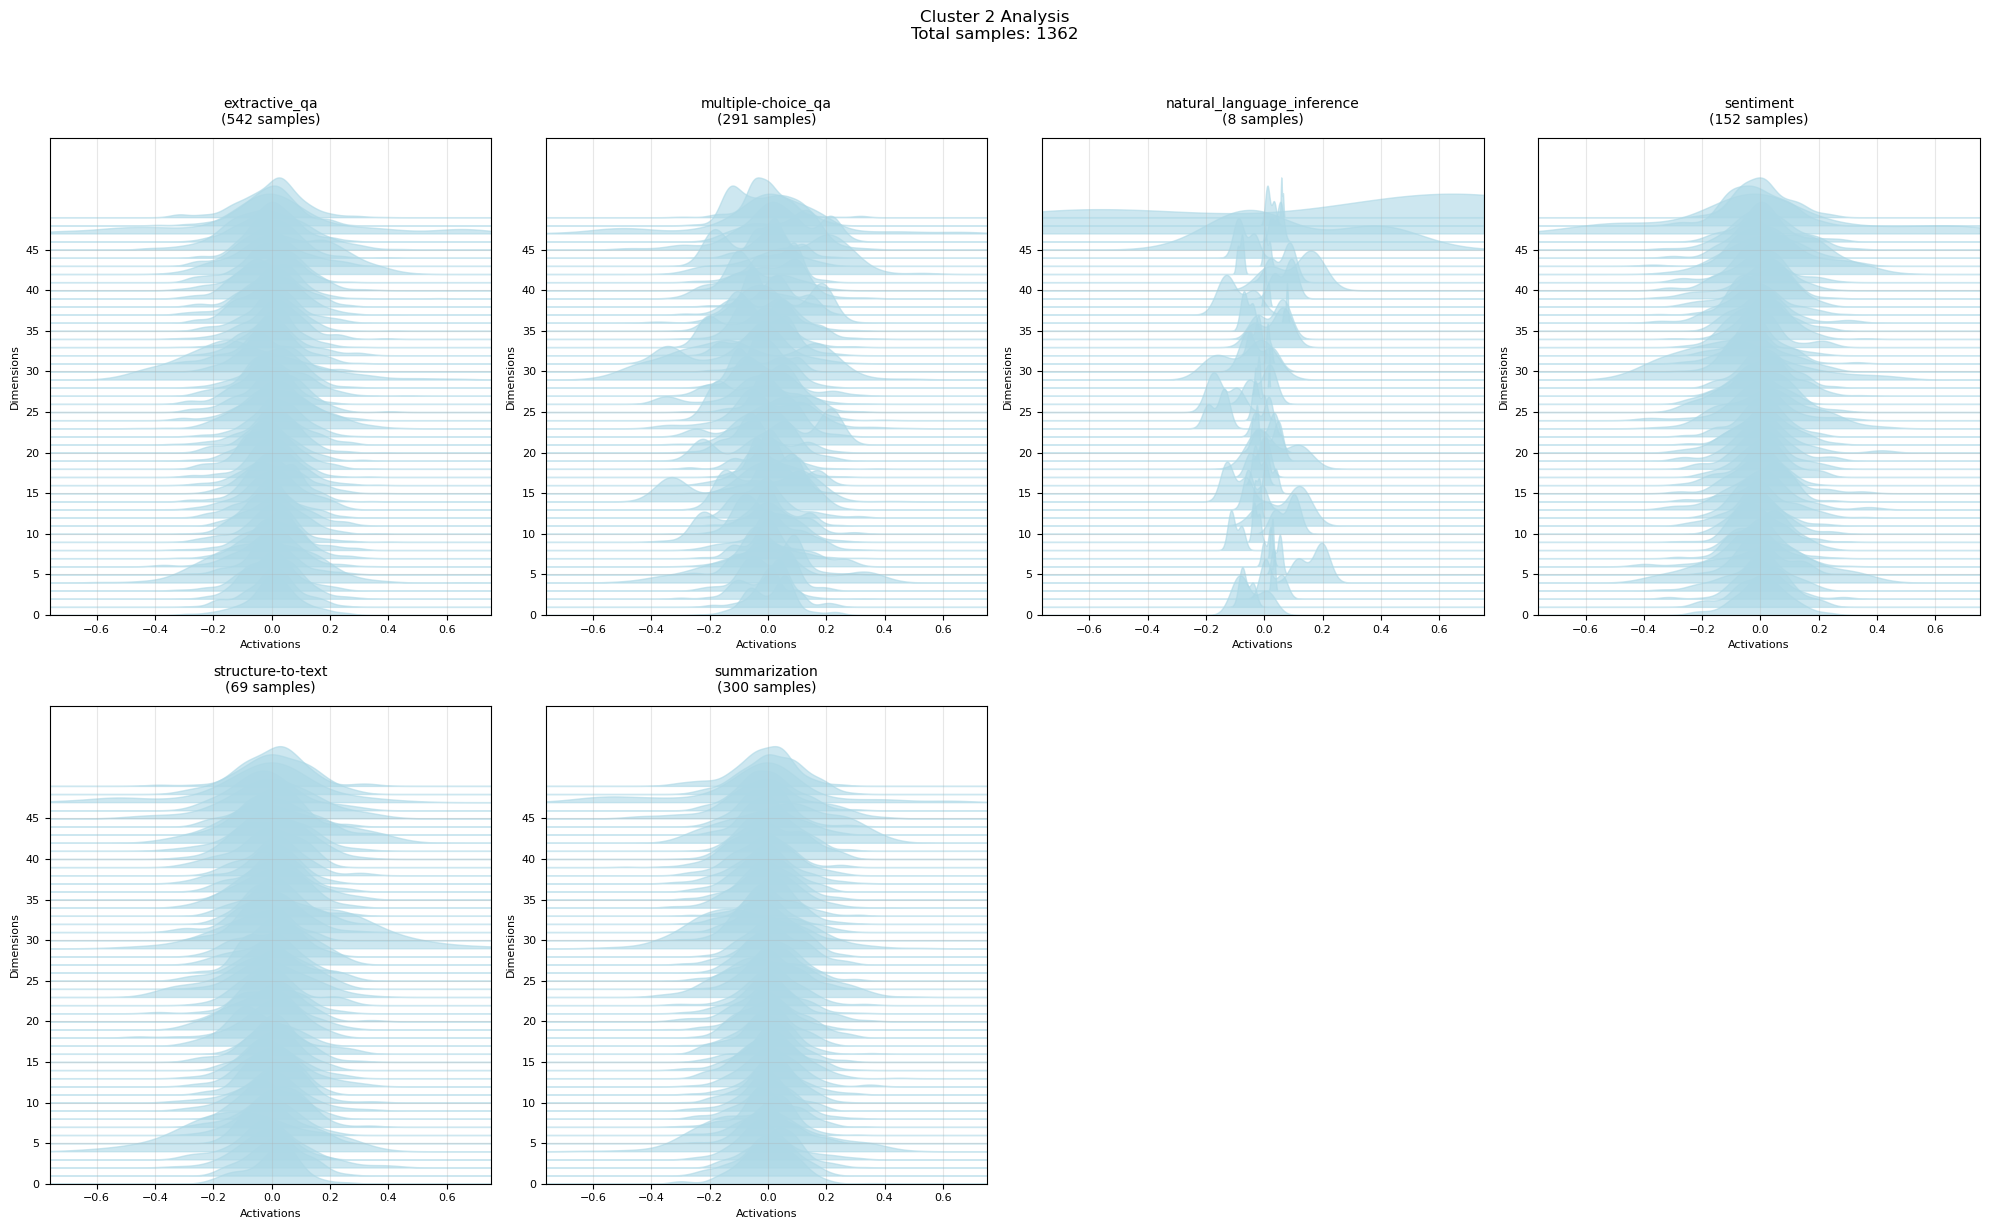


Cluster 3 composition:
close-book_qa: 158 samples (4.9%)
coreference_resolution: 605 samples (18.9%)
extractive_qa: 7 samples (0.2%)
multiple-choice_qa: 246 samples (7.7%)
natural_language_inference: 78 samples (2.4%)
paraphrase_identification: 350 samples (10.9%)
sentence_completion: 363 samples (11.3%)
sentiment: 67 samples (2.1%)
structure-to-text: 414 samples (12.9%)
summarization: 33 samples (1.0%)
topic_classification: 10 samples (0.3%)
word_sense_disambiguation: 868 samples (27.1%)
Total samples: 3199

Counts for Cluster 3 ridgeplot:
Total samples in ridgeplot: 3199


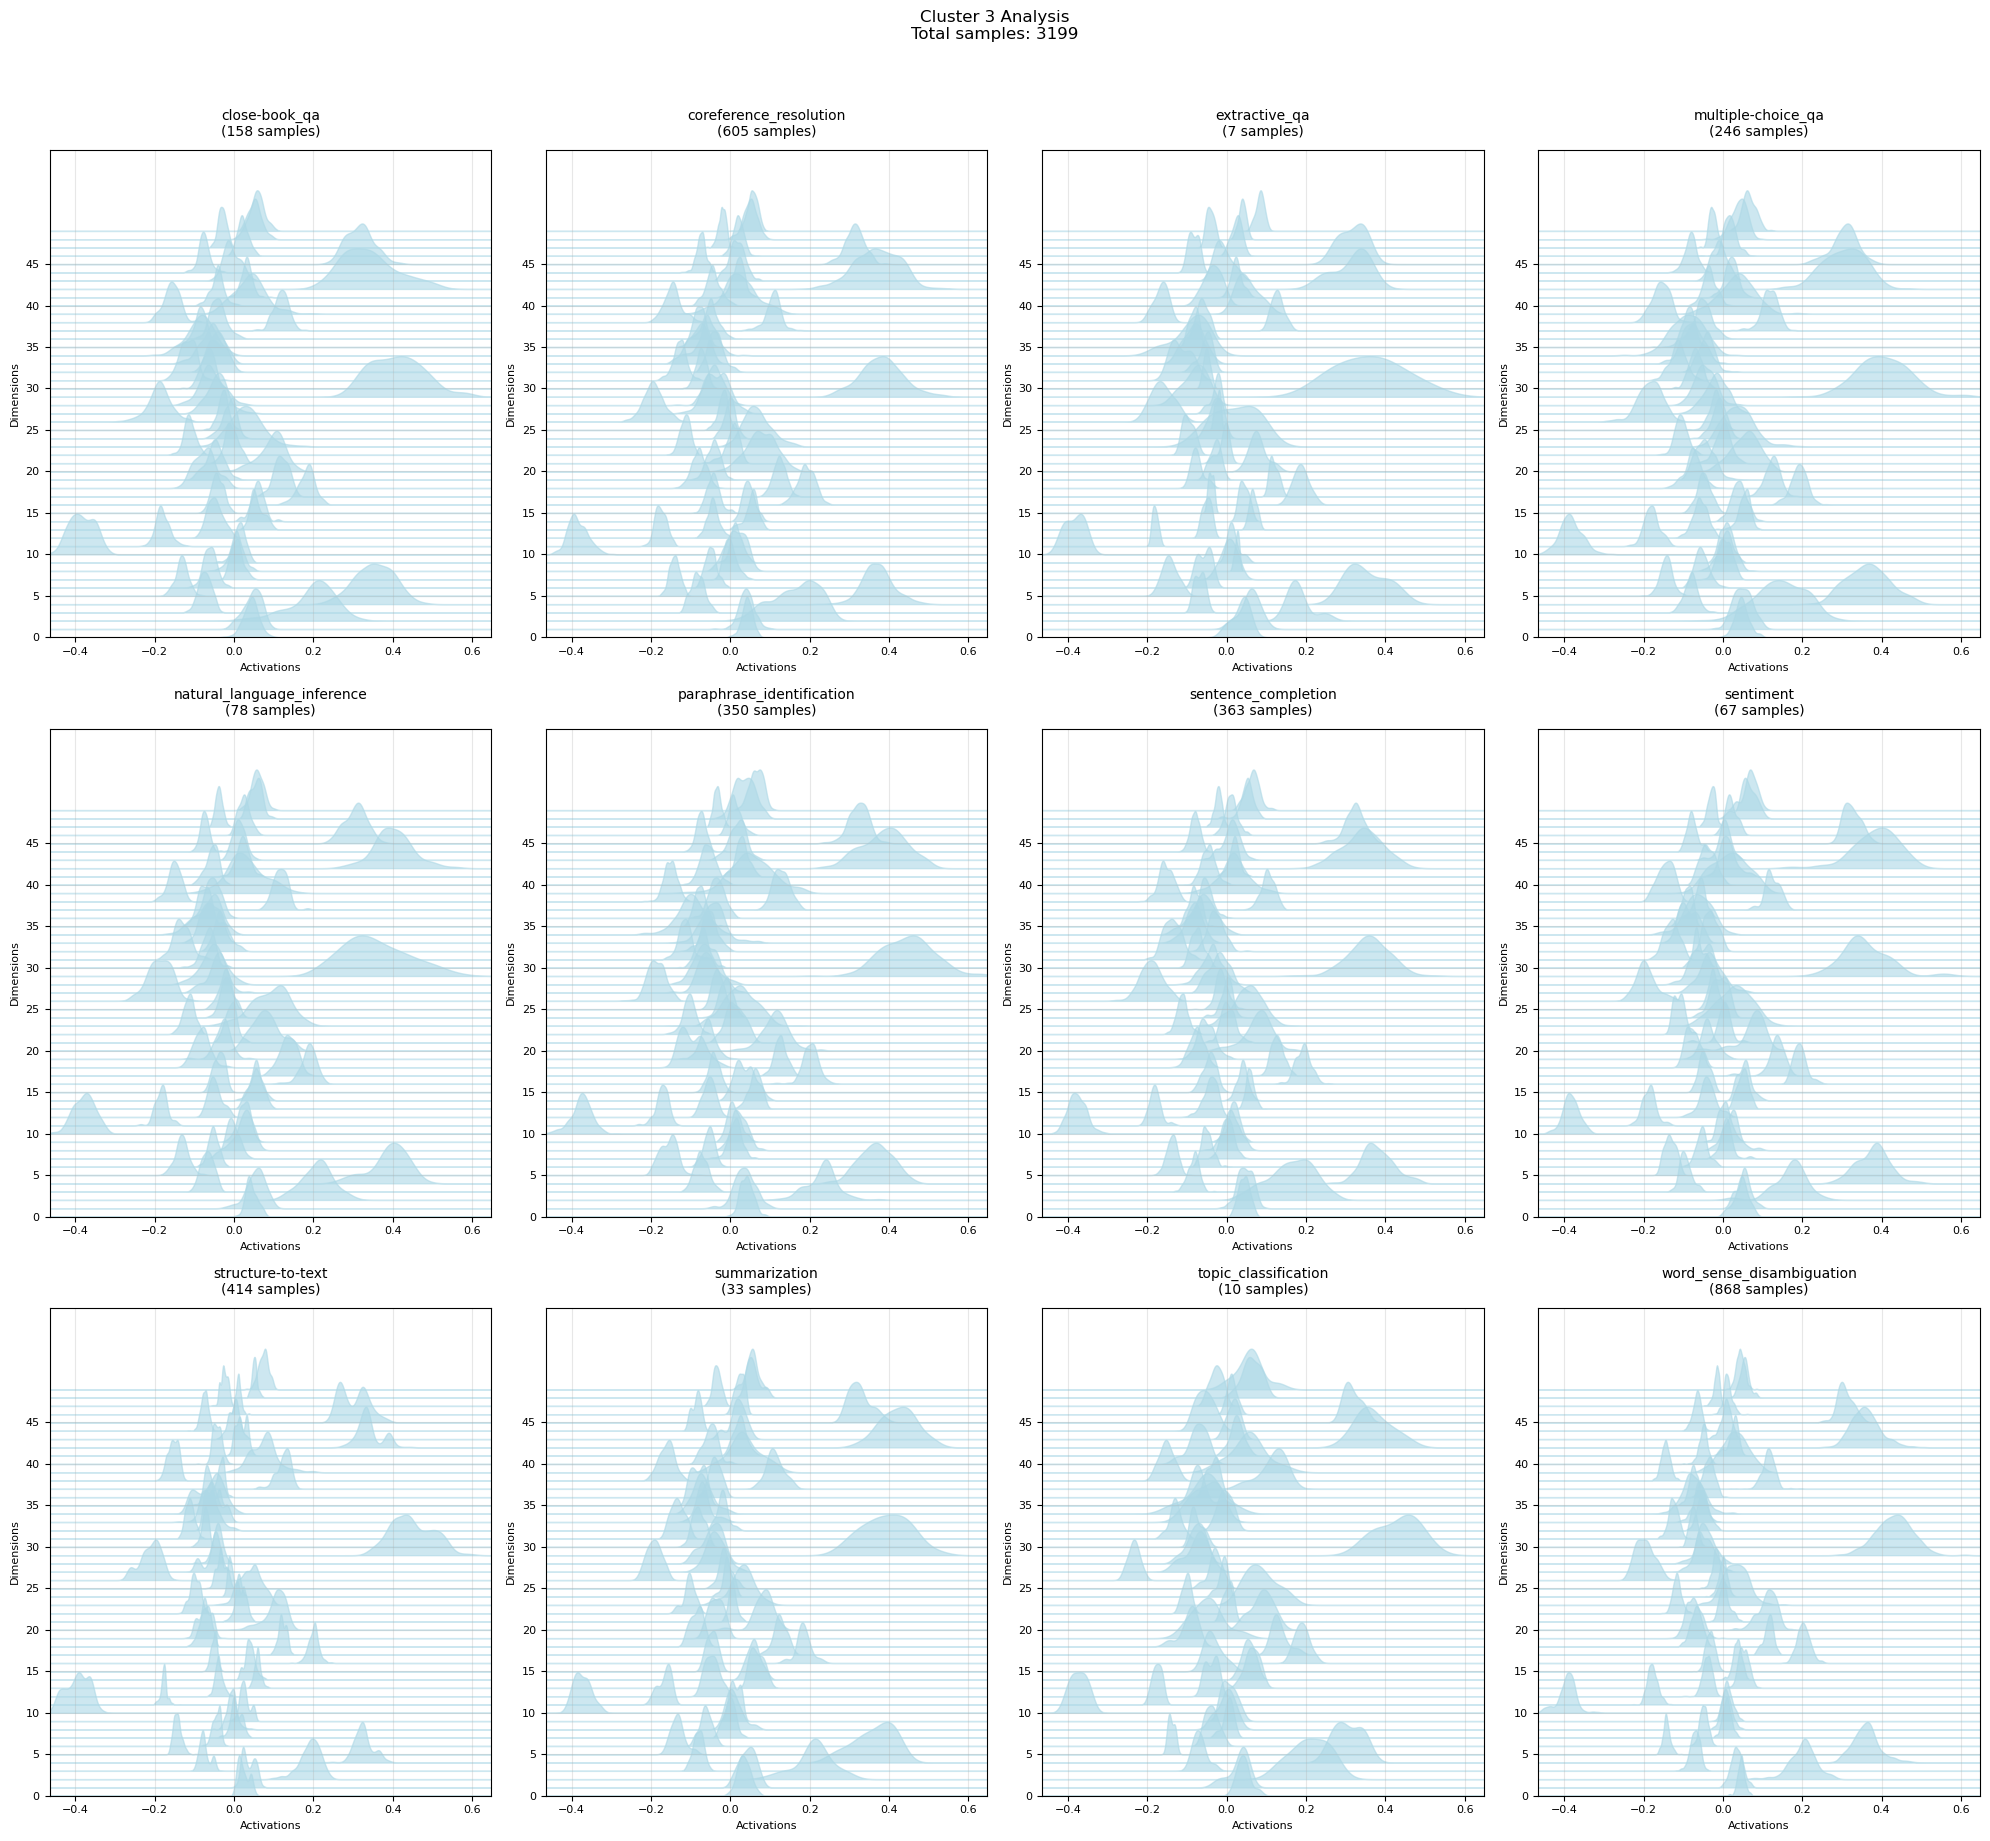

In [6]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_ridgeplot(ax, data, name, global_min, global_max, n_plots=50):
    # Take first n_plots dimensions
    total_dims = data.shape[1]
    if total_dims > n_plots:
        selected_dims = np.arange(n_plots)  # Take first n_plots dimensions
        data_sample = data[:, selected_dims]
    else:
        selected_dims = np.arange(total_dims)
        data_sample = data
    
    positions = np.linspace(0, 1, len(selected_dims))
    x = np.linspace(global_min, global_max, 1000)

    for i, (pos, col) in enumerate(zip(positions, data_sample.T)):
        kde = gaussian_kde(col)
        y = kde(x)
        y = y / y.max() * 0.1
        ax.fill_between(x, pos, pos + y, alpha=0.6, color='#ADD8E6')

    ax.set_title(f"{name}\n({data.shape[0]} samples)", fontsize=10, pad=10)
    ax.set_xlabel('Activations', fontsize=8)
    ax.set_ylabel('Dimensions', fontsize=8)
    ax.set_yticks(positions[::5])
    ax.set_yticklabels(selected_dims[::5])
    ax.set_ylim(0, 1.2)
    ax.set_xlim(global_min, global_max)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True, alpha=0.3)

def analyze_cluster(data_dict, cluster_id, n_plots=50):
    n_files = len(data_dict)
    n_cols = 4
    n_rows = (n_files + n_cols - 1) // n_cols
    
    # Print  counts for this cluster
    print(f"\nCounts for Cluster {cluster_id} ridgeplot:")
    total_samples = sum(len(data) for data in data_dict.values())
    print(f"Total samples in ridgeplot: {total_samples}")
    
    fig = plt.figure(figsize=(20, 6 * n_rows))
    
    # Calculate global min and max for first n_plots dimensions only
    global_min = min(np.min(data[:, :n_plots]) for data in data_dict.values())
    global_max = max(np.max(data[:, :n_plots]) for data in data_dict.values())
    
    for i, (name, data) in enumerate(sorted(data_dict.items())):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plot_ridgeplot(ax, data, name, global_min, global_max, n_plots)
    
    plt.suptitle(f'Cluster {cluster_id} Analysis\nTotal samples: {total_samples}', y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# Main execution
if 'X' in locals() and 'labels' in locals():
    
    # Clustering with k=4
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    
    # Create index ranges for each file
    start_idx = 0
    label_indices = {}
    unique_labels = sorted(set(labels))
    
    for label in unique_labels:
        label_mask = np.array(labels) == label
        label_data = X[label_mask]
        end_idx = start_idx + len(label_data)
        label_indices[label] = (start_idx, end_idx)
        start_idx = end_idx
    
    # Print overall cluster distribution
    print("\nOverall cluster distribution:")
    for cluster_id in range(n_clusters):
        print(f"Cluster {cluster_id}: {np.sum(clusters == cluster_id)} samples")
    
    # Analyze each cluster
    for cluster_id in range(n_clusters):
        cluster_mask = clusters == cluster_id
        
        # Create dictionary of data for each file in this cluster
        cluster_data = {}
        for label, (start, end) in label_indices.items():
            file_mask = cluster_mask[start:end]
            if np.any(file_mask):
                cluster_data[label] = X[start:end][file_mask]
        
        # Print cluster composition
        print(f"\nCluster {cluster_id} composition:")
        total_samples = 0
        for name, data in sorted(cluster_data.items()):
            samples = len(data)
            total_samples += samples
            print(f"{name}: {samples} samples ({samples/np.sum(cluster_mask)*100:.1f}%)")
        print(f"Total samples: {total_samples}")
        
        # Create ridgeplots for this cluster
        analyze_cluster(cluster_data, cluster_id)

else:
    print("Error: No data loaded. Please run the previous code to load the embeddings first.")

# Weighted + SVM Analysis

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import os
from collections import defaultdict

def get_reference_stats(train_data):
    """Calculate reference statistics from training data"""
    train_centroid = np.mean(train_data, axis=0)
    train_distances = np.linalg.norm(train_data - train_centroid, axis=1)
    distance_mean = np.mean(train_distances)
    distance_std = np.std(train_distances)
    threshold = distance_mean + 2.5 * distance_std
    
    return {
        'centroid': train_centroid,
        'mean': distance_mean,
        'std': distance_std,
        'threshold': threshold
    }

def get_anomaly_labels(data, reference_stats):
    """Label data points using reference statistics"""
    distances = np.linalg.norm(data - reference_stats['centroid'], axis=1)
    return (distances > reference_stats['threshold']).astype(int)

def get_distinctive_dimensions(data, cluster_labels, n_dimensions=10):
    """Get distinctive dimensions using only Cohen's d"""
    distinctiveness_scores = []
    
    for dim in range(data.shape[1]):
        dim_scores = []
        for i in range(max(cluster_labels) + 1):
            for j in range(i+1, max(cluster_labels) + 1):
                values_i = data[cluster_labels == i, dim]
                values_j = data[cluster_labels == j, dim]
                
                if len(values_i) > 0 and len(values_j) > 0:
                    cohens_d = abs(values_i.mean() - values_j.mean()) / np.sqrt(
                        (values_i.var() + values_j.var()) / 2)
                    dim_scores.append(cohens_d)
        
        distinctiveness_scores.append((dim, np.mean(dim_scores) if dim_scores else 0))
    
    top_dims = sorted(distinctiveness_scores, key=lambda x: x[1], reverse=True)[:n_dimensions]
    dims, scores = zip(*top_dims)
    weights = np.array(scores) / sum(scores)
    
    return np.array(dims), np.array(weights)

def evaluate_fold(train_data, test_data, n_dimensions=10, k=4):
    """Evaluate methods on a single fold"""
    # Get reference statistics and labels
    reference_stats = get_reference_stats(train_data)
    test_labels = get_anomaly_labels(test_data, reference_stats)
    train_labels = get_anomaly_labels(train_data, reference_stats)
    expected_outlier_fraction = np.mean(train_labels)
    
    # Get distinctive dimensions
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(train_data)
    dims, weights = get_distinctive_dimensions(train_data, cluster_labels, n_dimensions=n_dimensions)
    
    # Weighted Method
    all_scores = []
    for dim, weight in zip(dims, weights):
        min_val = train_data[:, dim].min()
        max_val = train_data[:, dim].max()
        values = test_data[:, dim]
        scores = np.zeros_like(values)
        scores[values < min_val] = np.abs(values[values < min_val] - min_val) / np.abs(min_val)
        scores[values > max_val] = np.abs(values[values > max_val] - max_val) / np.abs(max_val)
        all_scores.append(scores * weight)
    
    w_scores = np.mean(all_scores, axis=0)
    w_pred = (w_scores > np.percentile(w_scores, 95)).astype(int)
    
   
    
    # One-Class SVM (selected dimensions)
    train_selected = train_data[:, dims]
    test_selected = test_data[:, dims]
    svm_selected = OneClassSVM(kernel='rbf', nu=nu)
    svm_selected.fit(train_selected)
    svm_selected_pred = (svm_selected.predict(test_selected) == -1).astype(int)
    
 
    
    # Calculate metrics
    fold_results = {}
    for name, pred in [('weighted', w_pred), 
                      ('svm_selected', svm_selected_pred)]:
        fold_results[name] = {
            'accuracy': accuracy_score(test_labels, pred),
            'precision': precision_score(test_labels, pred, zero_division=0),
            'recall': recall_score(test_labels, pred, zero_division=0),
            'f1': f1_score(test_labels, pred, zero_division=0)
        }
    
    return fold_results

def cross_validate(data, n_folds=5, n_dimensions=10, k=4):
    """Perform k-fold cross-validation"""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    cv_results = defaultdict(lambda: defaultdict(list))
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(data), 1):
        print(f"\nEvaluating fold {fold}/{n_folds}...")
        train_data = data[train_idx]
        test_data = data[test_idx]
        
        fold_results = evaluate_fold(train_data, test_data, n_dimensions, k)
        
        # Collect results
        for method in fold_results:
            for metric, value in fold_results[method].items():
                cv_results[method][metric].append(value)
    
    # Calculate mean and std for each metric
    final_results = {}
    for method in cv_results:
        final_results[method] = {
            metric: {
                'mean': np.mean(values),
                'std': np.std(values)
            }
            for metric, values in cv_results[method].items()
        }
    
    return final_results

if __name__ == "__main__":
    files = [f for f in os.listdir('plots') if f.endswith('.npy')]
    all_embeddings = []

    print("Loading files:")
    for file_name in files:
        embeddings = np.load(f'plots/{file_name}')
        print(f"- {file_name}: {embeddings.shape}")
        all_embeddings.append(embeddings)

    combined_embeddings = np.vstack(all_embeddings)
    np.random.seed(42)
    combined_embeddings = shuffle(combined_embeddings, random_state=42)
    print(f"\nShape after combining and shuffling: {combined_embeddings.shape}")

    # Perform cross-validation
    cv_results = cross_validate(combined_embeddings, n_folds=5)

    # Print results
    print("\nCross-validation Results:")
    print("-" * 80)
    for method in cv_results:
        print(f"\n{method.upper()} Results:")
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            mean = cv_results[method][metric]['mean']
            std = cv_results[method][metric]['std']
            print(f"{metric.capitalize():>10}: {mean:.3f} ± {std:.3f}")

    # Print method comparisons
    print("\nMethod Comparisons (mean differences):")
    print("-" * 80)
    methods = list(cv_results.keys())
    for i in range(len(methods)):
        for j in range(i+1, len(methods)):
            method1, method2 = methods[i], methods[j]
            print(f"\n{method1.upper()} vs {method2.upper()}:")
            for metric in ['accuracy', 'precision', 'recall', 'f1']:
                diff = (cv_results[method1][metric]['mean'] - 
                       cv_results[method2][metric]['mean'])
                print(f"{metric.capitalize():>10}: {diff:.3f}")

Loading files:
- close-book_qa.npy: (1000, 4096)
- multiple-choice_qa.npy: (1000, 4096)
- coreference_resolution.npy: (1000, 4096)
- paraphrase_identification.npy: (1000, 4096)
- natural_language_inference.npy: (1000, 4096)
- extractive_qa.npy: (1000, 4096)
- topic_classification.npy: (1000, 4096)
- word_sense_disambiguation.npy: (1000, 4096)
- summarization.npy: (1000, 4096)
- sentence_completion.npy: (1000, 4096)
- sentiment.npy: (1000, 4096)
- structure-to-text.npy: (1000, 4096)

Shape after combining and shuffling: (12000, 4096)

Evaluating fold 1/5...

Evaluating fold 2/5...

Evaluating fold 3/5...

Evaluating fold 4/5...

Evaluating fold 5/5...
